In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

datapath = 'data/online_pareidolia_12-2024.csv'

data = pd.read_csv(datapath)
data = data['data_json']
data = json.loads(data[9])

In [216]:
len(data['trials'][13]['webgazer_data'])

285

In [223]:
import json
import pandas as pd
import json
import pandas as pd

def extract_data(data, id=0):
    
    data = json.loads(data[id])
    # Initialize lists to store the extracted data
    idx = []
    rts = []
    words = []
    descriptions = []
    images = []
    eye_tracking = []
    
    # Keep track of the previous trial's image URL
    prev_image_url = None
    t = -1
    # Iterate through each trial in the 'trials' list
    for e, trial in enumerate(data['trials']):
        # Update the image URL if the current trial has one
        if 'url_stimulus' in trial:
            prev_image_url = trial['url_stimulus']
        if 'webgazer_data' in trial:
            webgazer_data = trial['webgazer_data']
        
        
        # Check if the trial contains a 'data' key and then proceed
        if 'data' in trial:
            t += 1
            trial_data = trial['data']
            # Iterate over each possible word/description pair
            words_ = []
            descriptions_ = []
            for i in range(1, 6):  # Assuming there are up to 5 words/descriptions per trial
                word_key = f'word{i}'
                desc_key = f'description{i}'
                # Check if the word is present and not empty
                if word_key in trial_data and trial_data[word_key]:
                    # Append the data to the lists, including the RT and the previous image URL
                    
                    words_.append(trial_data[word_key])
                    descriptions_.append(trial_data.get(desc_key, ''))  # Use an empty string if no description
            words.append(words_)
            descriptions.append(descriptions_)
            idx.append(t)
            rts.append(data['trials'][e-1]['rt'])
            images.append(prev_image_url)
            try:
                eye_tracking.append(webgazer_data)
            except:
                eye_tracking.append(None)
            # if words are empty strings, append empty string for the trial
            if all([not trial_data.get(f'word{i}', '') for i in range(1, 6)]):
                idx.append(t)
                # get rt for the trial before the actual trial
                rts.append(data['trials'][e-1]['rt'])
                words.append('')
                descriptions.append('')
                images.append(prev_image_url)
                try:
                    eye_tracking.append(webgazer_data)
                except:
                    eye_tracking.append(None)
    
    # Create a DataFrame with the collected data
    df = pd.DataFrame({
        'trial': idx,
        'rt': rts,
        'words': words,
        'n_words': [len(w) for w in words],
        'description': descriptions,
        'image': images,
        'eye_tracking': eye_tracking
    })
    df['FD'] = df['image'].apply(lambda x: float(x.split('/FD_')[1].split('_')[0])/10 if x and '/FD_' in x else None)
    # remove first row
    df = df[2:]
    return df


datapath = 'data/online_pareidolia_12-2024.csv'
data = pd.read_csv(datapath)
data = data['data_json']
# Initialize an empty list to store DataFrames for each participant
all_participants_data = []

# Loop through all participants in the data
for participant_id in range(len(data)):
    # Extract data for the current participant
    participant_df = extract_data(data, id=participant_id)
    participant_df['participant_id'] = participant_id
    # Append the resulting DataFrame to the list
    all_participants_data.append(participant_df)

# Concatenate all the participant DataFrames into a single DataFrame
final_df = pd.concat(all_participants_data, ignore_index=True)

# Save the final DataFrame if needed
# final_df.to_csv('data/online_pareidolia_extracted_all.csv', index=False)
final_df.head()


trial  rt             words  n_words  \
0      1 NaN           [earth]        1   
1      2 NaN  [kissing, alien]        2   
2      3 NaN         [smoking]        1   
3      4 NaN         [dancing]        1   
4      5 NaN           [genie]        1   

                                         description  \
0                                                 []   
1  [two people about to kiss, an alien looking down]   
2                                [a fat man smoking]   
3                    [a dancing llama and his owner]   
4                   [a genie coming out of a bottle]   

                      image  \
0  images/FD16/FD_16_94.png   
1  images/FD12/FD_12_31.png   
2  images/FD12/FD_12_93.png   
3  images/FD16/FD_16_44.png   
4  images/FD14/FD_14_49.png   

                                        eye_tracking   FD  participant_id  
0  [{'x': 524, 'y': 252, 't': None}, {'x': 374, '...  1.6               0  
1  [{'x': 610, 'y': 340, 't': None}, {'x': 670, '...  1.2               0  
2  [{'x': 629, 'y': 145, 't': None}, {'x': 638, '...  1.2               0  
3  [{'x': 419, 'y': 397, 't': None}, {'x': 405, '...  1.6               0  
4  [{'x': 363, 'y': 260, 't': None}, {'x': 199, '...  1.4               0

In [238]:
# Parameters for fixation detection
SPATIAL_THRESHOLD = 300  # Adjust spatial threshold (pixels)
TEMPORAL_THRESHOLD = 800  # Adjust temporal threshold (ms)

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Helper function to detect fixations
# Helper function to detect fixations
def detect_fixations(x_coords, y_coords, timestamps):
    fixations = []
    current_fixation = []
    start_time = None
    centroid_x, centroid_y = None, None  # Centroid of the current fixation

    for i in range(len(x_coords)):
        if not current_fixation:
            # Start a new fixation
            current_fixation.append((x_coords[i], y_coords[i], timestamps[i]))
            start_time = timestamps[i]
            centroid_x, centroid_y = x_coords[i], y_coords[i]
        else:
            # Compute distance from centroid
            distance = euclidean_distance(centroid_x, centroid_y, x_coords[i], y_coords[i])
            duration = timestamps[i] - start_time

            if distance < SPATIAL_THRESHOLD:
                # Add point to current fixation
                current_fixation.append((x_coords[i], y_coords[i], timestamps[i]))
                # Update the centroid
                centroid_x = np.mean([p[0] for p in current_fixation])
                centroid_y = np.mean([p[1] for p in current_fixation])
            elif duration > TEMPORAL_THRESHOLD:
                # End fixation if it exceeds temporal threshold
                fixations.append(current_fixation)
                current_fixation = [(x_coords[i], y_coords[i], timestamps[i])]
                start_time = timestamps[i]
                centroid_x, centroid_y = x_coords[i], y_coords[i]

    # Append the last fixation
    if current_fixation and len(current_fixation) > 1:
        fixations.append(current_fixation)

    return fixations


# Trial length in milliseconds
TRIAL_LENGTH_MS = 10_000  # 10 seconds

# Updated fixation detection and metrics computation
for idx, row in final_df.iterrows():
    if isinstance(row['eye_tracking'], list):  # Ensure valid eye-tracking data
        eye_data = row['eye_tracking']

        # Extract x, y coordinates
        valid_points = [
            (point['x'], point['y']) 
            for point in eye_data 
            if 'x' in point and 'y' in point
        ]
        
        if len(valid_points) > 1:
            x_coords, y_coords = zip(*valid_points)
            
            # Dynamically calculate sampling interval
            sampling_interval = TRIAL_LENGTH_MS / len(x_coords)  # in milliseconds

            # Generate synthetic timestamps
            timestamps = [i * sampling_interval for i in range(len(x_coords))]

            # Detect fixations
            fixations = detect_fixations(x_coords, y_coords, timestamps)
            
            # 1. Fixation Count
            fixation_count = len(fixations)
            final_df.at[idx, 'fixation_count'] = fixation_count
            
            # 2. Mean Fixation Duration
            fixation_durations = [fix[-1][2] - fix[0][2] for fix in fixations]  # Duration of each fixation
            if fixation_durations:
                final_df.at[idx, 'mean_fixation_duration'] = np.mean(fixation_durations)
            
            # 3. Fixation Dispersion
            all_fixation_points = [(fix[0][0], fix[0][1]) for fix in fixations]
            if all_fixation_points:
                x_fix = [p[0] for p in all_fixation_points]
                y_fix = [p[1] for p in all_fixation_points]
                fixation_dispersion = np.sqrt(np.var(x_fix) + np.var(y_fix))
                final_df.at[idx, 'fixation_dispersion'] = fixation_dispersion
            
            # 4. Scanpath Length
            scanpath_length = sum(
                euclidean_distance(x_coords[i], y_coords[i], x_coords[i + 1], y_coords[i + 1])
                for i in range(len(x_coords) - 1)
            )
            final_df.at[idx, 'scanpath_length'] = scanpath_length
            
            # 5. Entropy
            position_pairs = list(zip(x_coords, y_coords))
            unique_positions, counts = np.unique(position_pairs, axis=0, return_counts=True)
            probabilities = counts / counts.sum()
            entropy = -np.sum(probabilities * np.log2(probabilities))
            final_df.at[idx, 'entropy'] = entropy


In [239]:
final_df[0:5]

trial  rt             words  n_words  \
0      1 NaN           [earth]        1   
1      2 NaN  [kissing, alien]        2   
2      3 NaN         [smoking]        1   
3      4 NaN         [dancing]        1   
4      5 NaN           [genie]        1   

                                         description  \
0                                                 []   
1  [two people about to kiss, an alien looking down]   
2                                [a fat man smoking]   
3                    [a dancing llama and his owner]   
4                   [a genie coming out of a bottle]   

                      image  \
0  images/FD16/FD_16_94.png   
1  images/FD12/FD_12_31.png   
2  images/FD12/FD_12_93.png   
3  images/FD16/FD_16_44.png   
4  images/FD14/FD_14_49.png   

                                        eye_tracking   FD  participant_id  \
0  [{'x': 524, 'y': 252, 't': None}, {'x': 374, '...  1.6               0   
1  [{'x': 610, 'y': 340, 't': None}, {'x': 670, '...  1.2               0   
2  [{'x': 629, 'y': 145, 't': None}, {'x': 638, '...  1.2               0   
3  [{'x': 419, 'y': 397, 't': None}, {'x': 405, '...  1.6               0   
4  [{'x': 363, 'y': 260, 't': None}, {'x': 199, '...  1.4               0   

   fixation_count  scanpath_length   entropy  mean_fixation_duration  \
0             3.0      3873.476377  8.112565             3299.319728   
1             1.0      1655.712139  7.700121             9965.986395   
2             1.0      2024.576596  8.001483             9965.870307   
3             2.0      3878.769314  8.114519             4965.870307   
4             2.0      4134.555923  8.157384             4965.635739   

   fixation_dispersion  
0           200.631780  
1             0.000000  
2             0.000000  
3            92.359353  
4            39.824616

## Compare Eye Tracking metrics across FDs

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=3.306e-01 stat=-1.000e+00
1.4 v.s. 1.6: t-test independent samples, P_val=4.583e-01 stat=7.579e-01
1.2 v.s. 1.6: t-test independent samples, P_val=7.915e-01 stat=-2.683e-01


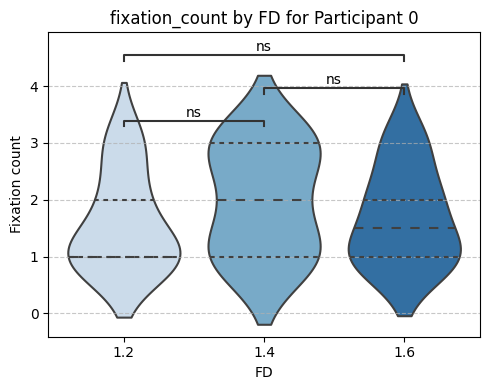

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=5.850e-02 stat=-2.020e+00
1.4 v.s. 1.6: t-test independent samples, P_val=2.188e-01 stat=1.274e+00
1.2 v.s. 1.6: t-test independent samples, P_val=3.677e-01 stat=-9.240e-01


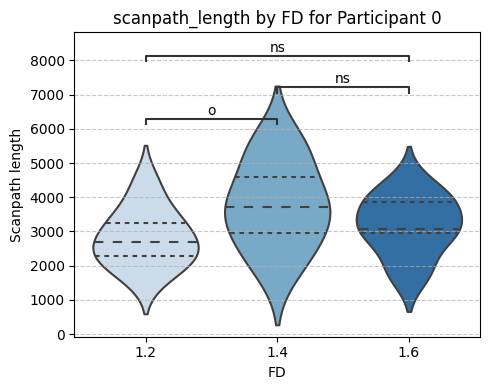

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=3.696e-01 stat=-9.203e-01
1.4 v.s. 1.6: t-test independent samples, P_val=7.312e-01 stat=3.489e-01
1.2 v.s. 1.6: t-test independent samples, P_val=4.637e-01 stat=-7.488e-01


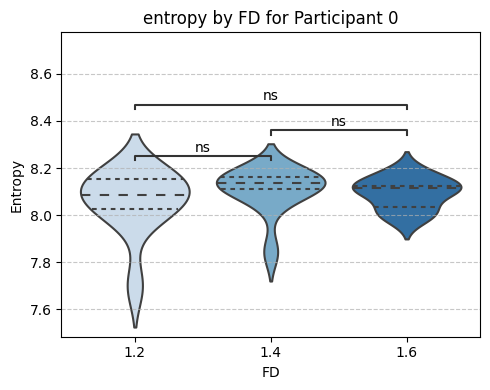

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=3.676e-01 stat=9.241e-01
1.4 v.s. 1.6: t-test independent samples, P_val=5.581e-01 stat=-5.967e-01
1.2 v.s. 1.6: t-test independent samples, P_val=7.369e-01 stat=3.412e-01


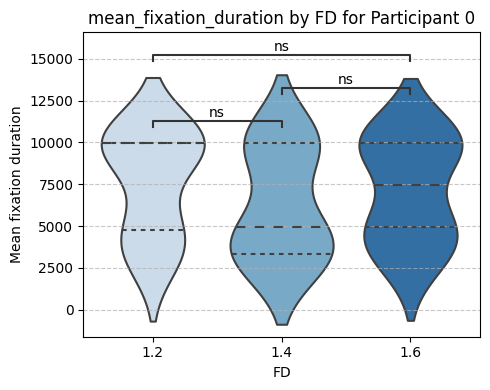

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=9.666e-01 stat=4.248e-02
1.4 v.s. 1.6: t-test independent samples, P_val=8.393e-01 stat=2.058e-01
1.2 v.s. 1.6: t-test independent samples, P_val=8.240e-01 stat=2.256e-01


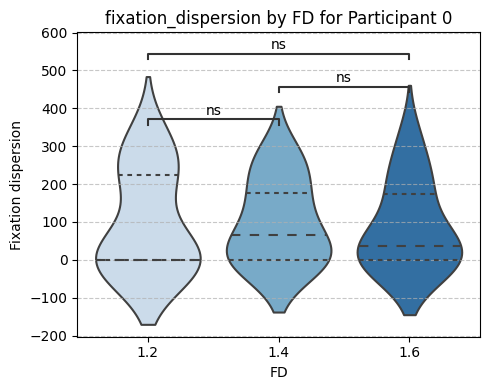

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=nan stat=nan
1.4 v.s. 1.6: t-test independent samples, P_val=nan stat=nan
1.2 v.s. 1.6: t-test independent samples, P_val=nan stat=nan


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\statannot\statannot.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(a=box_data1, b=box_data2, **stats_params)


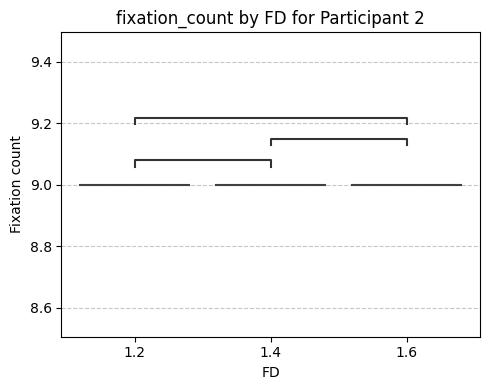

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=nan stat=nan
1.4 v.s. 1.6: t-test independent samples, P_val=nan stat=nan
1.2 v.s. 1.6: t-test independent samples, P_val=nan stat=nan


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\statannot\statannot.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(a=box_data1, b=box_data2, **stats_params)


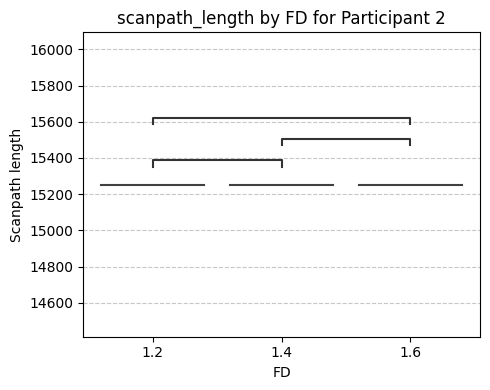

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=nan stat=nan
1.4 v.s. 1.6: t-test independent samples, P_val=nan stat=nan
1.2 v.s. 1.6: t-test independent samples, P_val=nan stat=nan


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\statannot\statannot.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(a=box_data1, b=box_data2, **stats_params)


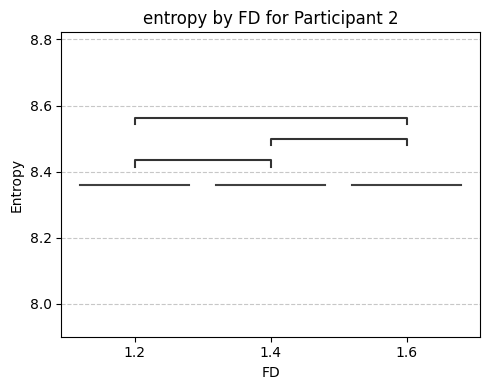

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=1.000e+00 stat=0.000e+00
1.4 v.s. 1.6: t-test independent samples, P_val=1.000e+00 stat=0.000e+00
1.2 v.s. 1.6: t-test independent samples, P_val=1.000e+00 stat=0.000e+00


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\statannot\statannot.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(a=box_data1, b=box_data2, **stats_params)


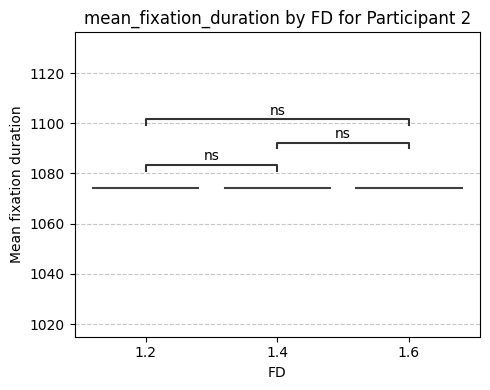

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=nan stat=nan
1.4 v.s. 1.6: t-test independent samples, P_val=nan stat=nan
1.2 v.s. 1.6: t-test independent samples, P_val=nan stat=nan


c:\Users\User\anaconda3\envs\goofi\lib\site-packages\statannot\statannot.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(a=box_data1, b=box_data2, **stats_params)


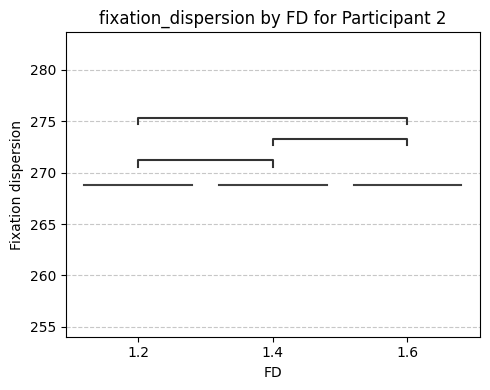

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=1.000e+00 stat=0.000e+00
1.4 v.s. 1.6: t-test independent samples, P_val=4.230e-01 stat=-8.199e-01
1.2 v.s. 1.6: t-test independent samples, P_val=3.693e-01 stat=-9.210e-01


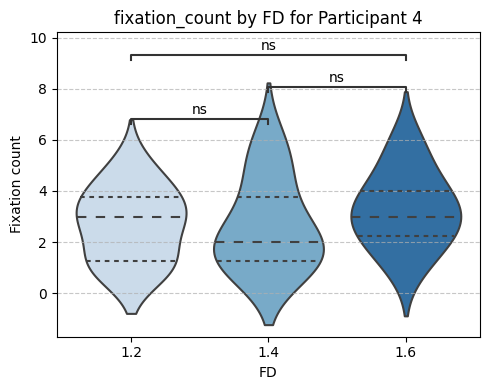

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=6.687e-01 stat=-4.350e-01
1.4 v.s. 1.6: t-test independent samples, P_val=2.703e-01 stat=1.137e+00
1.2 v.s. 1.6: t-test independent samples, P_val=5.504e-01 stat=6.086e-01


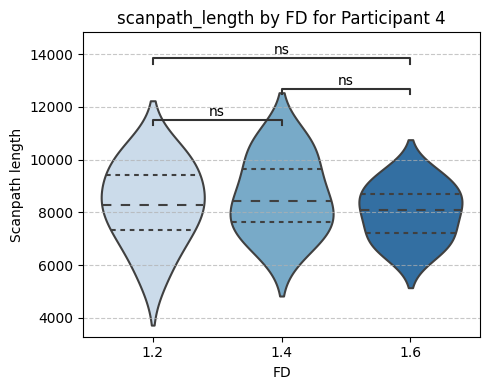

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=1.000e+00 stat=0.000e+00
1.4 v.s. 1.6: t-test independent samples, P_val=6.509e-01 stat=-4.602e-01
1.2 v.s. 1.6: t-test independent samples, P_val=6.509e-01 stat=-4.602e-01


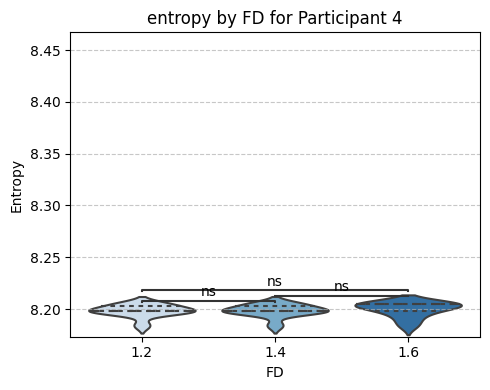

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=8.677e-01 stat=-1.690e-01
1.4 v.s. 1.6: t-test independent samples, P_val=2.369e-01 stat=1.223e+00
1.2 v.s. 1.6: t-test independent samples, P_val=3.210e-01 stat=1.021e+00


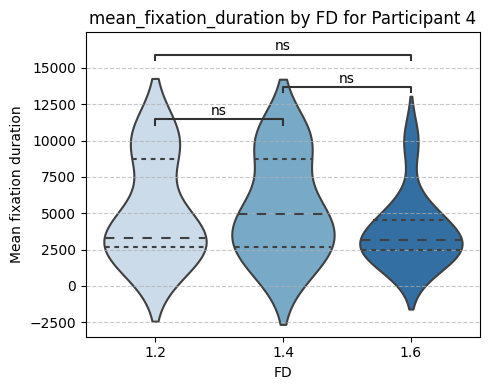

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=5.441e-01 stat=6.184e-01
1.4 v.s. 1.6: t-test independent samples, P_val=2.487e-02 stat=-2.447e+00
1.2 v.s. 1.6: t-test independent samples, P_val=8.797e-02 stat=-1.804e+00


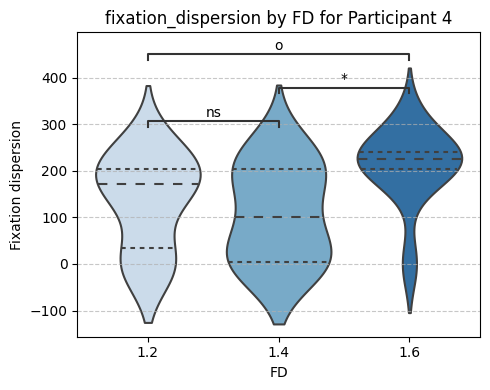

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=3.901e-01 stat=8.776e-01
1.4 v.s. 1.6: t-test independent samples, P_val=4.820e-01 stat=7.153e-01
1.2 v.s. 1.6: t-test independent samples, P_val=1.521e-01 stat=1.486e+00


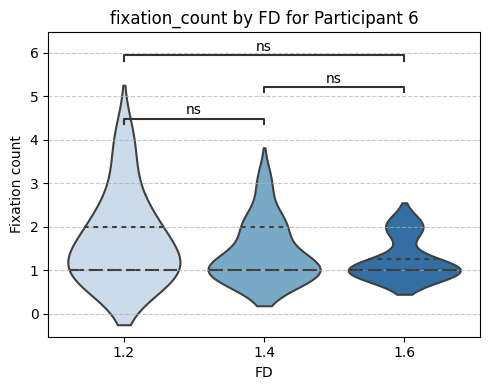

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=5.126e-01 stat=6.661e-01
1.4 v.s. 1.6: t-test independent samples, P_val=2.397e-01 stat=1.208e+00
1.2 v.s. 1.6: t-test independent samples, P_val=5.794e-02 stat=2.006e+00


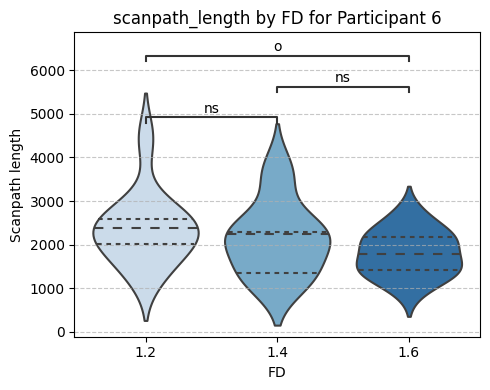

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=8.715e-01 stat=-1.638e-01
1.4 v.s. 1.6: t-test independent samples, P_val=3.761e-01 stat=9.034e-01
1.2 v.s. 1.6: t-test independent samples, P_val=4.610e-01 stat=7.510e-01


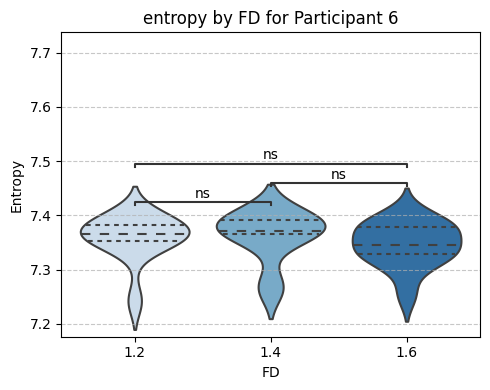

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=4.898e-01 stat=-7.029e-01
1.4 v.s. 1.6: t-test independent samples, P_val=5.905e-01 stat=-5.460e-01
1.2 v.s. 1.6: t-test independent samples, P_val=2.273e-01 stat=-1.244e+00


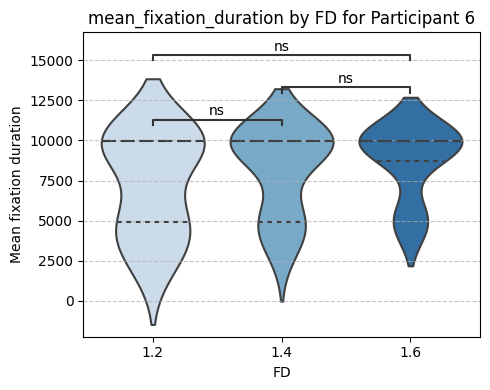

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=6.689e-01 stat=4.337e-01
1.4 v.s. 1.6: t-test independent samples, P_val=7.911e-01 stat=2.681e-01
1.2 v.s. 1.6: t-test independent samples, P_val=4.897e-01 stat=7.032e-01


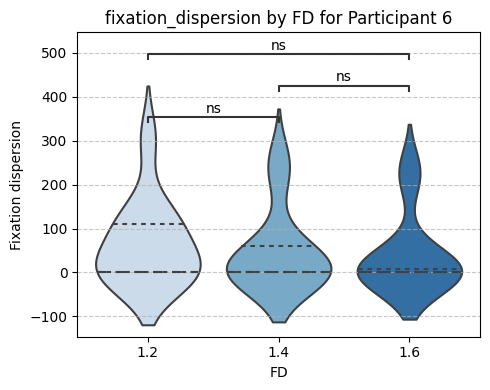

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=9.201e-01 stat=1.016e-01
1.4 v.s. 1.6: t-test independent samples, P_val=4.752e-01 stat=7.265e-01
1.2 v.s. 1.6: t-test independent samples, P_val=5.195e-01 stat=6.556e-01


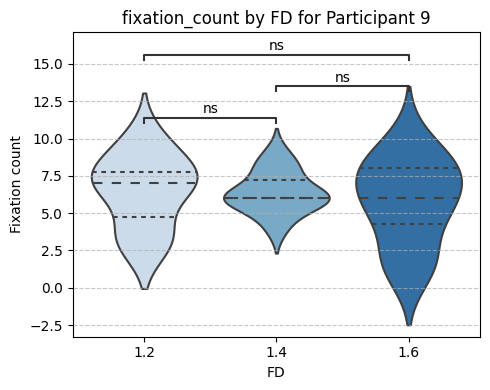

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=8.970e-01 stat=1.311e-01
1.4 v.s. 1.6: t-test independent samples, P_val=6.775e-01 stat=4.214e-01
1.2 v.s. 1.6: t-test independent samples, P_val=6.293e-01 stat=4.903e-01


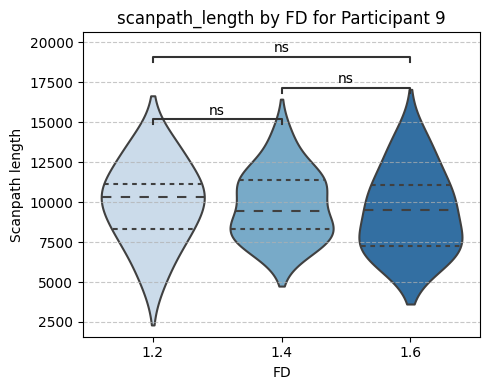

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=4.910e-01 stat=7.016e-01
1.4 v.s. 1.6: t-test independent samples, P_val=4.972e-01 stat=-6.904e-01
1.2 v.s. 1.6: t-test independent samples, P_val=9.689e-01 stat=-3.947e-02


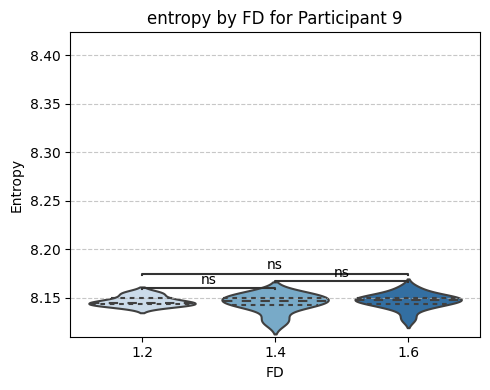

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=6.433e-01 stat=4.702e-01
1.4 v.s. 1.6: t-test independent samples, P_val=1.761e-01 stat=-1.398e+00
1.2 v.s. 1.6: t-test independent samples, P_val=2.946e-01 stat=-1.076e+00


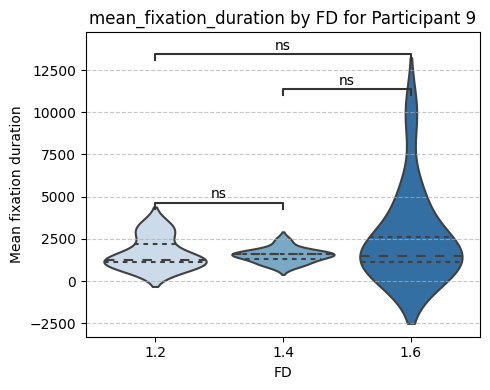

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

1.2 v.s. 1.4: t-test independent samples, P_val=2.704e-01 stat=1.134e+00
1.4 v.s. 1.6: t-test independent samples, P_val=6.965e-01 stat=3.952e-01
1.2 v.s. 1.6: t-test independent samples, P_val=3.291e-01 stat=1.000e+00


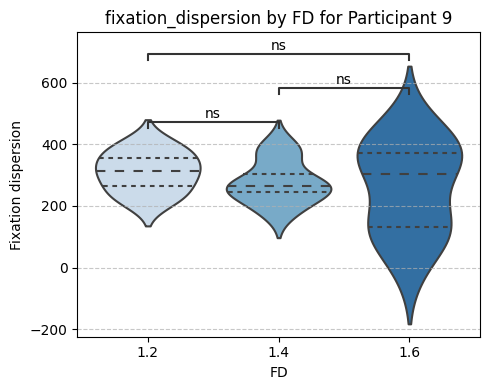

In [242]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

# List of metrics to plot
metrics = ['fixation_count', 'scanpath_length', 'entropy', 'mean_fixation_duration', 'fixation_dispersion']

# Filter participants with eye-tracking data
participants_with_eye_tracking = final_df[final_df['eye_tracking'].notnull()]['participant_id'].unique()

# Generate violin plots for each participant
for participant in participants_with_eye_tracking:
    participant_data = final_df[final_df['participant_id'] == participant]
    
    for metric in metrics:
        plt.figure(figsize=(5, 4))
        ax = sns.violinplot(
            data=participant_data,
            x='FD',
            y=metric,
            palette='Blues',
            scale='width',
            inner='quartile'
        )
        
        # Define pairwise comparisons for FD
        fd_values = sorted(participant_data['FD'].unique())
        pairwise_comparisons = list(combinations(fd_values, 2))
        
        # Add statistical annotations
        add_stat_annotation(
            ax,
            data=participant_data,
            x='FD',
            y=metric,
            box_pairs=pairwise_comparisons,
            test='t-test_ind',
            text_format='star',
            loc='inside',
            verbose=2,
            comparisons_correction=None,
            pvalue_thresholds=[[1e-3, "***"], [1e-2, "**"], [0.05, "*"], [0.1, "o"], [1, "ns"]],
        )
        
        # Customize plot
        plt.title(f'{metric} by FD for Participant {participant}')
        plt.xlabel('FD')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()



Fitting Mixed-Effects Model for fixation_count...
            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: fixation_count
No. Observations:  129     Method:             REML          
No. Groups:        4       Scale:              2.2238        
Min. group size:   30      Log-Likelihood:     -240.3351     
Max. group size:   35      Converged:          Yes           
Mean group size:   32.2                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           3.646    1.573  2.317 0.020  0.562  6.730
FD                 -0.401    0.809 -0.495 0.620 -1.987  1.186
participant_id Var  4.665    2.622                           



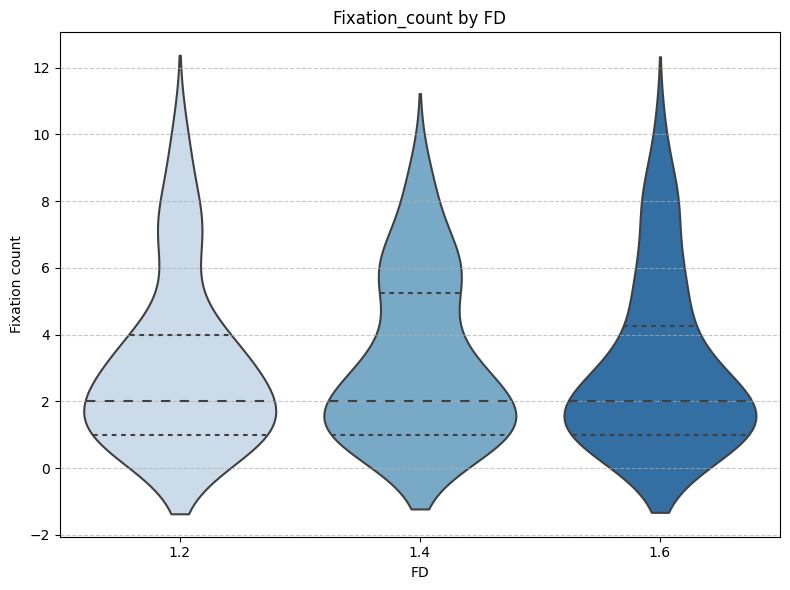


Fitting Mixed-Effects Model for scanpath_length...
                  Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     scanpath_length
No. Observations:     129         Method:                 REML           
No. Groups:           4           Scale:                  2204794.4920   
Min. group size:      30          Log-Likelihood:         -1118.7113     
Max. group size:      35          Converged:              Yes            
Mean group size:      32.2                                               
-------------------------------------------------------------------------
                      Coef.     Std.Err.   z    P>|z|   [0.025    0.975] 
-------------------------------------------------------------------------
Intercept              6877.660 2184.995  3.148 0.002  2595.149 11160.171
FD                     -729.087  805.968 -0.905 0.366 -2308.755   850.582
participant_id Var 13903509.837 7770.329                                 



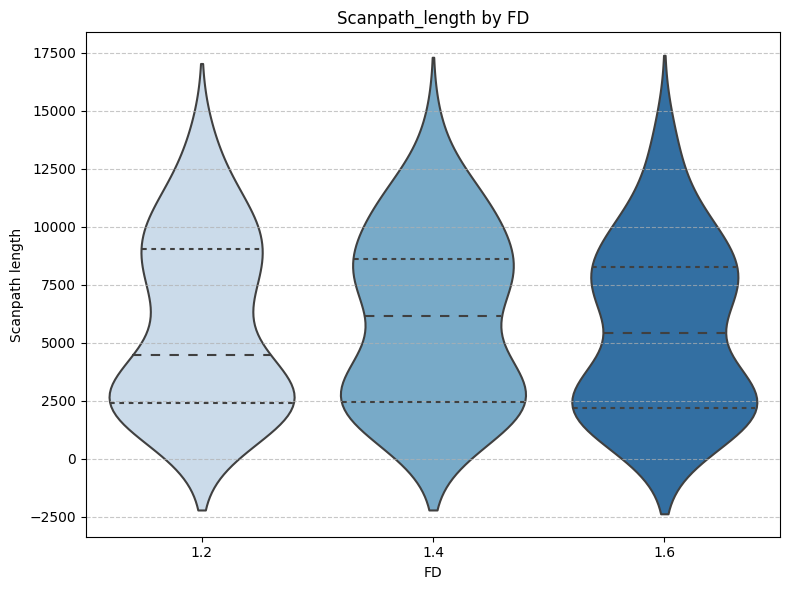


Fitting Mixed-Effects Model for entropy...
           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   entropy 
No. Observations:   129       Method:               REML    
No. Groups:         4         Scale:                0.0030  
Min. group size:    30        Log-Likelihood:       173.5698
Max. group size:    35        Converged:            Yes     
Mean group size:    32.2                                    
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          7.927    0.202 39.154 0.000  7.531  8.324
FD                 0.013    0.030  0.448 0.654 -0.045  0.072
participant_id Var 0.157    2.344                           



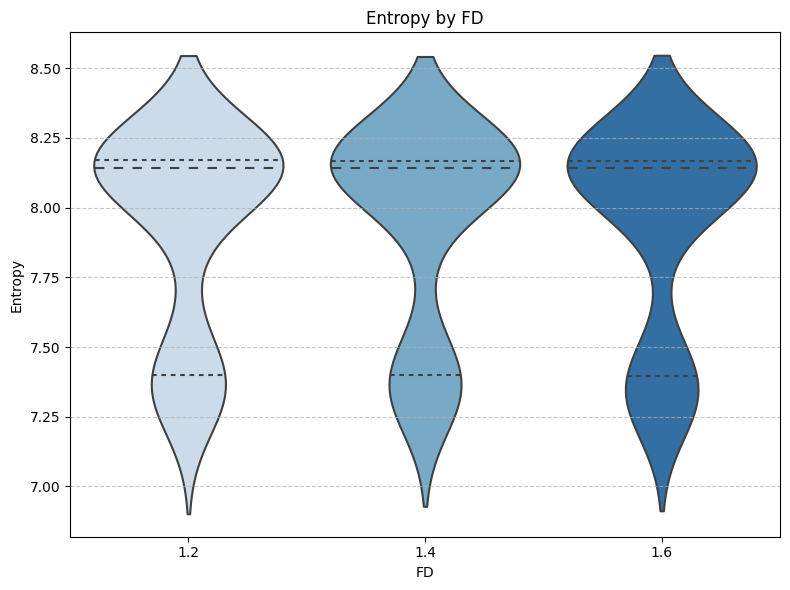


Fitting Mixed-Effects Model for mean_fixation_duration...
                Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: mean_fixation_duration
No. Observations:   129     Method:             REML                  
No. Groups:         4       Scale:              7214505.8700          
Min. group size:    30      Log-Likelihood:     -1191.2338            
Max. group size:    35      Converged:          Yes                   
Mean group size:    32.2                                              
----------------------------------------------------------------------
                      Coef.    Std.Err.   z   P>|z|   [0.025   0.975] 
----------------------------------------------------------------------
Intercept             4729.351 2452.452 1.928 0.054   -77.367 9536.069
FD                     514.502 1457.927 0.353 0.724 -2342.983 3371.986
participant_id Var 7064597.437 2238.858                               



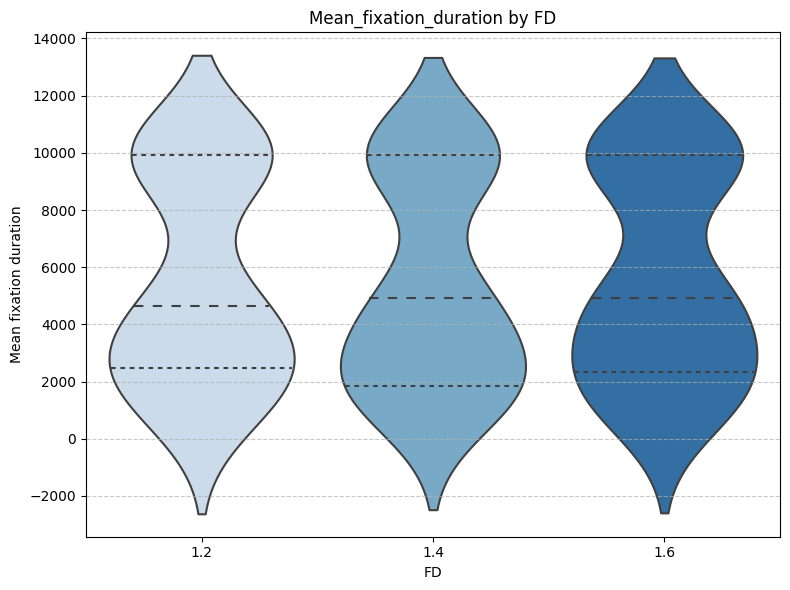


Fitting Mixed-Effects Model for fixation_dispersion...
              Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: fixation_dispersion
No. Observations:  129     Method:             REML               
No. Groups:        4       Scale:              10586.1516         
Min. group size:   30      Log-Likelihood:     -776.8211          
Max. group size:   35      Converged:          Yes                
Mean group size:   32.2                                           
------------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------
Intercept           165.519   92.847  1.783 0.075  -16.458 347.496
FD                  -14.342   55.847 -0.257 0.797 -123.801  95.117
participant_id Var 9546.854   79.186                              



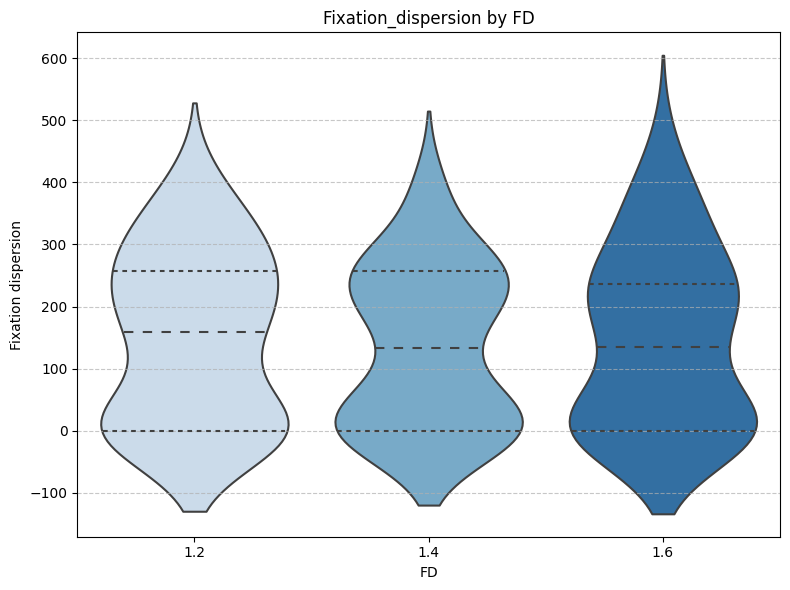

In [243]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# List of metrics to analyze
metrics = ['fixation_count', 'scanpath_length', 'entropy', 'mean_fixation_duration', 'fixation_dispersion']

# Filter out participant 2 and ensure data is valid
filtered_df = final_df[final_df['participant_id'] != 2].dropna(subset=['eye_tracking'])

# Results dictionary to store model summaries
model_results = {}

# Loop through each metric
for metric in metrics:
    print(f"\nFitting Mixed-Effects Model for {metric}...")
    
    # Fit the mixed-effects model
    formula = f"{metric} ~ FD"
    model = smf.mixedlm(formula, data=filtered_df, groups="participant_id", re_formula="~1")
    result = model.fit()
    
    # Store the results
    model_results[metric] = result.summary()
    
    # Print model summary
    print(result.summary())

    # Plot the metric with violin plots by FD
    plt.figure(figsize=(8, 6))
    sns.violinplot(
        data=filtered_df,
        x='FD',
        y=metric,
        palette='Blues',
        scale='width',
        inner='quartile'
    )
    plt.title(f'{metric.capitalize()} by FD')
    plt.xlabel('FD')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


## Compare Pareidolia across FDs

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.4 v.s. 1.6: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=6.331e-01
1.2 v.s. 1.4: t-test independent samples with Bonferroni correction, P_val=1.829e-01 stat=1.881e+00
1.2 v.s. 1.6: t-test independent samples with Bonferroni correction, P_val=3.768e-02 stat=2.511e+00


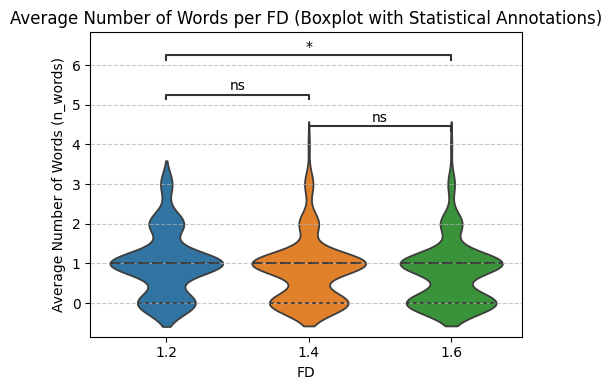

FD
1.2    1.000000
1.4    0.829114
1.6    0.773006
Name: n_words, dtype: float64

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations

# Boxplot of n_words per FD
plt.figure(figsize=(5, 4))
ax = sns.violinplot(
    data=final_df,
    x='FD',
    y='n_words',
    inner='quartile',
    linewidth=1.3
)

# Get unique FD values from the data in the same order as the boxplot
fd_values = final_df['FD'].dropna().unique()

# Define valid pairwise comparisons
pairwise_comparisons = [pair for pair in combinations(fd_values, 2) if pair[0] in fd_values and pair[1] in fd_values]

# Add statistical annotations
add_stat_annotation(
    ax,
    data=final_df,
    x='FD',
    y='n_words',
    box_pairs=pairwise_comparisons,
    test='t-test_ind',
    text_format='star',
    loc='inside',
    verbose=2,
    line_offset=0.2,
    linewidth=1.5,
)

# Customize the plot
plt.xlabel('FD')
plt.ylabel('Average Number of Words (n_words)')
plt.title('Average Number of Words per FD (Boxplot with Statistical Annotations)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# print average number of words per FD
final_df.groupby('FD')['n_words'].mean()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1.2 v.s. 1.4: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=6.484e-01
1.4 v.s. 1.6: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=4.095e-01
1.2 v.s. 1.6: t-test independent samples with Bonferroni correction, P_val=8.794e-01 stat=1.075e+00


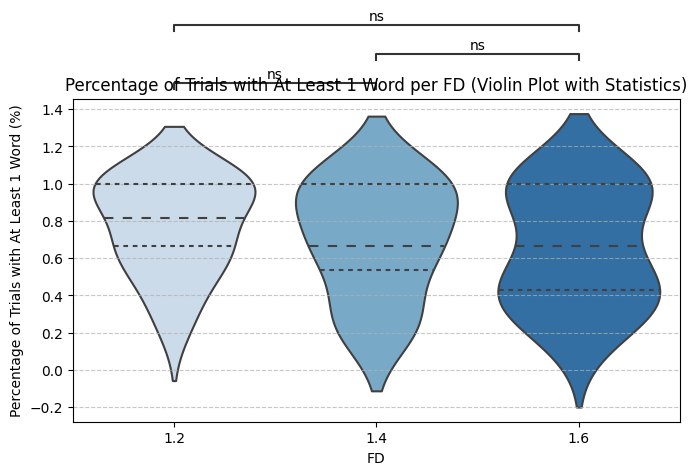

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from itertools import combinations
from statannot import add_stat_annotation

# Create the violin plot
plt.figure(figsize=(7, 5))
ax = sns.violinplot(
    x='FD', 
    y='percentage_trials', 
    data=percentage_trials, 
    scale='width', 
    inner='quartile', 
    palette='Blues'
)

# Define pairwise comparisons for all FD pairs
fd_values = sorted(percentage_trials['FD'].unique())
pairwise_comparisons = list(combinations(fd_values, 2))

# Add statistical annotations
add_stat_annotation(
    ax,
    data=percentage_trials,
    x='FD',
    y='percentage_trials',
    box_pairs=pairwise_comparisons,
    test='t-test_ind',
    text_format='star',
    loc='outside',
    verbose=2
)

# Customize the plot
plt.xlabel('FD')
plt.ylabel('Percentage of Trials with At Least 1 Word (%)')
plt.title('Percentage of Trials with At Least 1 Word per FD (Violin Plot with Statistics)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Participants with eye-tracking data: [0 2 4 6 9]


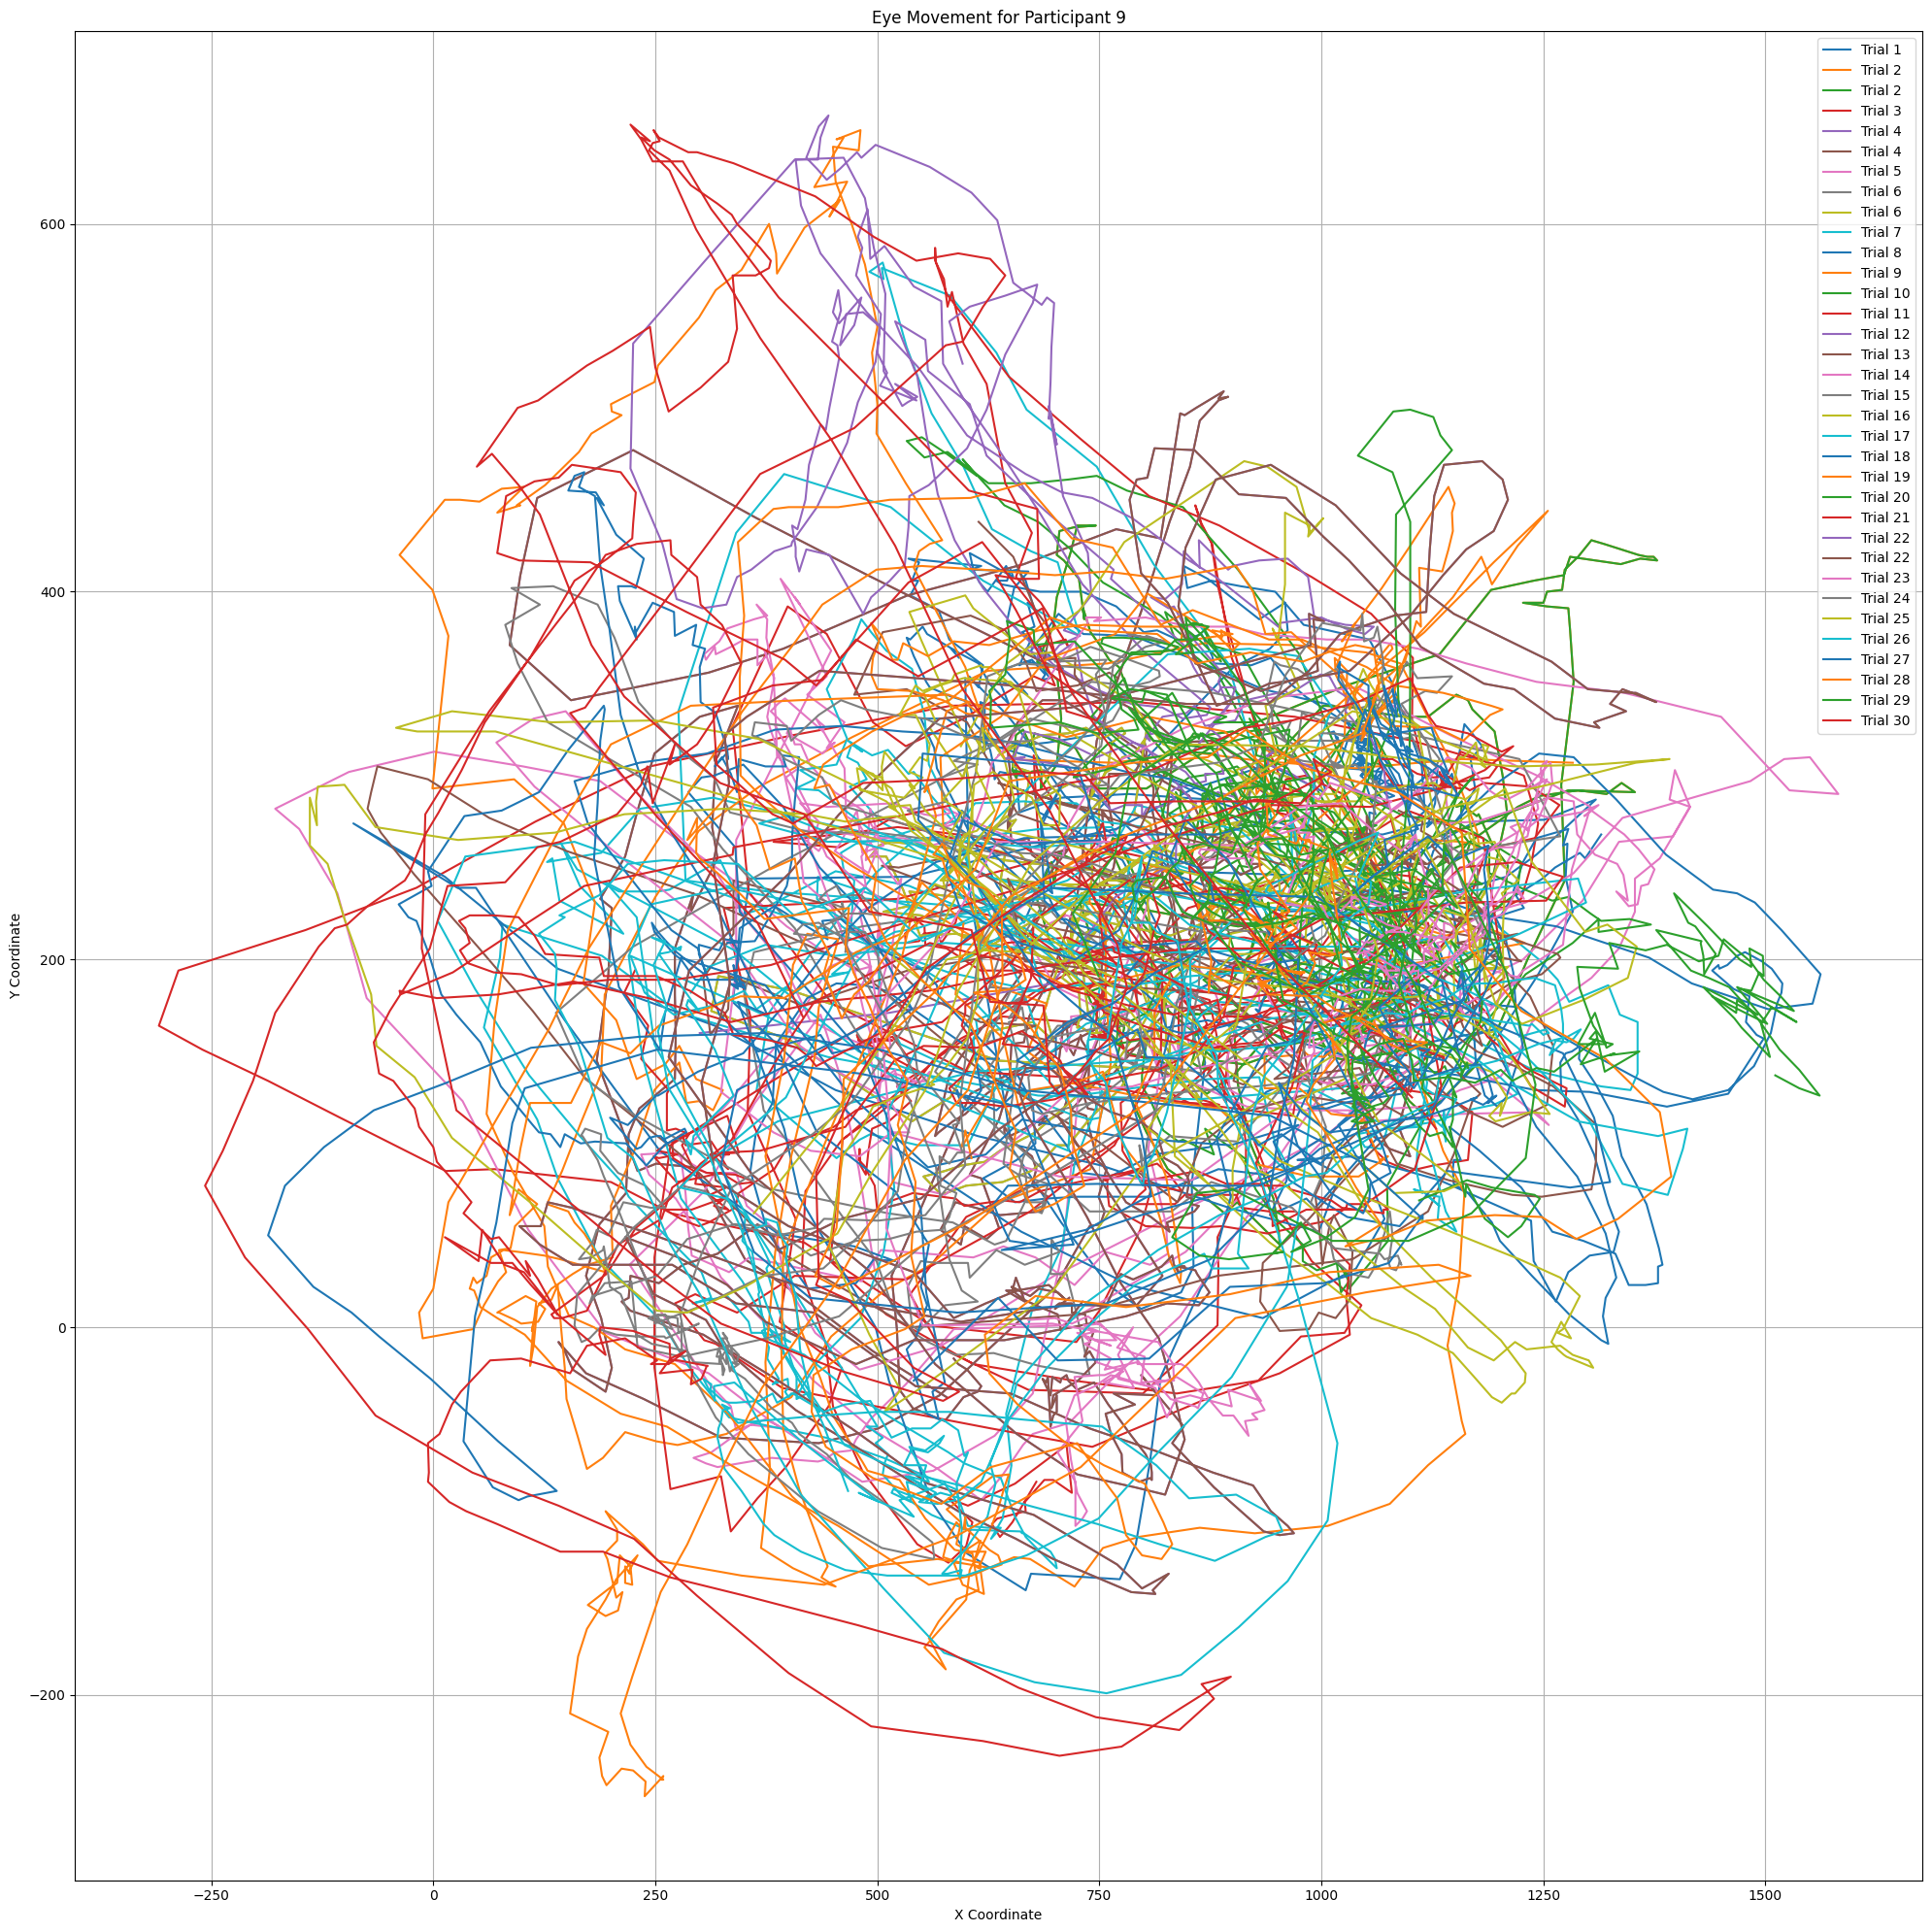

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Check which participants have eye-tracking data
participants_with_eye_tracking = final_df[final_df['eye_tracking'].notnull()]['participant_id'].unique()
print("Participants with eye-tracking data:", participants_with_eye_tracking)

# Step 2: Extract data for one participant with eye-tracking
participant_id_to_plot = participants_with_eye_tracking[4]  # Select the first participant
eye_tracking_data = final_df[
    (final_df['participant_id'] == participant_id_to_plot) & 
    (final_df['eye_tracking'].notnull())
]

# Step 3: Plot eye movement for each trial
plt.figure(figsize=(20, 20))
for trial in eye_tracking_data['trial'].unique():
    trial_data = eye_tracking_data[eye_tracking_data['trial'] == trial]
    for row in trial_data['eye_tracking']:
        if isinstance(row, list):  # Ensure valid data
            x_coords = [point['x'] for point in row if point.get('x') is not None]
            y_coords = [point['y'] for point in row if point.get('y') is not None]
            plt.plot(x_coords, y_coords, label=f'Trial {trial}')

# Customize the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Eye Movement for Participant {participant_id_to_plot}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
